In [34]:
import os
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Seed 고정
SEED=42
os.environ["PYTHONHASHSEED"]=str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# GPU 설정
gpus=tf.config.experimental.list_physical_devices("GPU")
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

In [35]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices("GPU")))

Num GPUs Available:  1


In [36]:
import cv2, os
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.image import imread
import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras import models, layers, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.applications import ResNet50
from keras.applications.resnet50 import preprocess_input
from keras.models import Sequential
from keras.layers import Dense

In [37]:
data_dir = "../../data/processed/02_kaggle_dataset/train"

train_datagen = ImageDataGenerator(validation_split=0.3,
                                   preprocessing_function=preprocess_input)  # don't use rescale = 1./255

train_generator = train_datagen.flow_from_directory(data_dir,
                                                    target_size=(224, 224),
                                                    batch_size=100,
                                                    shuffle=True,
                                                    class_mode='binary',
                                                    subset='training')

validation_datagen = ImageDataGenerator(validation_split=0.3,
                                        preprocessing_function=preprocess_input)

validation_generator = validation_datagen.flow_from_directory(data_dir,
                                                              target_size=(
                                                                  224, 224),
                                                              batch_size=100,
                                                              class_mode='binary',
                                                              subset='validation')

Found 33600 images belonging to 2 classes.
Found 14400 images belonging to 2 classes.


In [38]:
model_res50 = Sequential()

model_res50.add(ResNet50(
    include_top=False,
    pooling='avg',
    weights='imagenet'
))

model_res50.add(Dense(1, activation='sigmoid'))

model_res50.layers[0].trainable = False

model_res50.summary()


steps_per_epoch_training = len(train_generator)
steps_per_epoch_validation = len(validation_generator)

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense_10 (Dense)            (None, 1)                 2049      
                                                                 
Total params: 23589761 (89.99 MB)
Trainable params: 2049 (8.00 KB)
Non-trainable params: 23587712 (89.98 MB)
_________________________________________________________________


In [39]:
model_res50.compile(optimizer='adam',
                    loss='binary_crossentropy',
                    metrics=['accuracy'])

history = model_res50.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch_training,
    validation_steps=steps_per_epoch_validation,
    epochs=7,
    validation_data=validation_generator,
    verbose=1
)

Epoch 1/7
336/336 [==============================] - 110s 306ms/step - loss: 0.0739 - accuracy: 0.9787 - val_loss: 0.1687 - val_accuracy: 0.9371
Epoch 2/7
336/336 [==============================] - 102s 304ms/step - loss: 0.0320 - accuracy: 0.9908 - val_loss: 0.1971 - val_accuracy: 0.9358
Epoch 3/7
336/336 [==============================] - 102s 304ms/step - loss: 0.0253 - accuracy: 0.9923 - val_loss: 0.1848 - val_accuracy: 0.9392
Epoch 4/7
336/336 [==============================] - 98s 290ms/step - loss: 0.0218 - accuracy: 0.9932 - val_loss: 0.2198 - val_accuracy: 0.9361
Epoch 5/7
336/336 [==============================] - 102s 304ms/step - loss: 0.0193 - accuracy: 0.9937 - val_loss: 0.1928 - val_accuracy: 0.9396
Epoch 6/7
336/336 [==============================] - 102s 305ms/step - loss: 0.0175 - accuracy: 0.9942 - val_loss: 0.1893 - val_accuracy: 0.9401
Epoch 7/7
336/336 [==============================] - 103s 306ms/step - loss: 0.0162 - accuracy: 0.9949 - val_loss: 0.2296 - val_acc

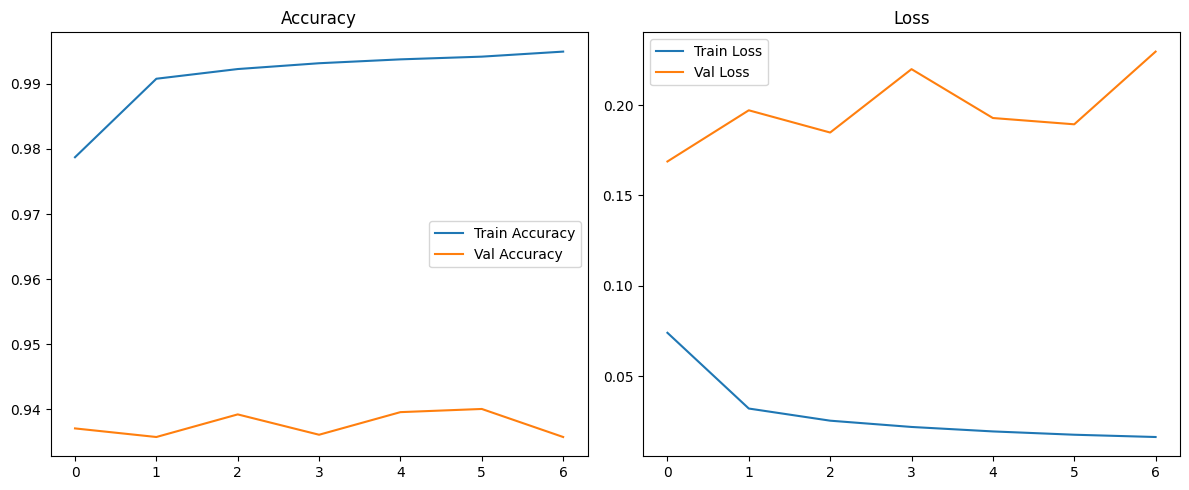

In [41]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Val Accuracy")
plt.legend()
plt.title("Accuracy")

plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.legend()
plt.title("Loss")

plt.tight_layout()
plt.show()

Found 14400 images belonging to 2 classes.
클래스 인덱스: {'closed': 0, 'open': 1}
144/144 [==============================] - 30s 209ms/step
              precision    recall  f1-score   support

      closed       0.89      0.99      0.94      7200
        open       0.99      0.88      0.93      7200

    accuracy                           0.94     14400
   macro avg       0.94      0.94      0.94     14400
weighted avg       0.94      0.94      0.94     14400



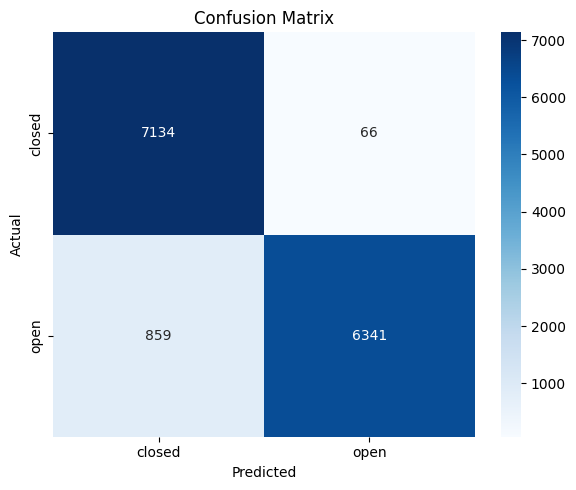

In [44]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# 1. validation_generator 설정 확인: 반드시 shuffle=False
validation_generator = validation_datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),
    batch_size=100,
    class_mode="binary",
    subset="validation",
    shuffle=False
)

# 2. class 인덱스 확인
print("클래스 인덱스:", validation_generator.class_indices)  # 예: {'closed': 0, 'open': 1}

# 3. 예측 전 반드시 reset
validation_generator.reset()

# 4. 예측 수행
pred_probs = model_res50.predict(validation_generator, verbose=1)
pred_labels = (pred_probs > 0.5).astype("int").reshape(-1)

# 5. 정답 레이블
true_labels = validation_generator.classes

# 6. classification_report 출력
target_names = list(validation_generator.class_indices.keys())  # ['closed', 'open'] 등
print(classification_report(true_labels, pred_labels, target_names=target_names))

# 7. Confusion Matrix
cm = confusion_matrix(true_labels, pred_labels)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=target_names, yticklabels=target_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()


In [ ]:
from keras.applications.resnet50 import preprocess_input

IMG_SIZE=32
BATCH_SIZE=32
DATA_PATH="../../data/processed/02_kaggle_dataset/train"

train_datagen=ImageDataGenerator(
    #rescale=1./255,
    preprocessing_function=preprocess_input,
    validation_split=0.2
)

val_datagen=ImageDataGenerator(
    #rescale=1./255,
    preprocessing_function=preprocess_input,
    validation_split=0.2
)

train_generator=train_datagen.flow_from_directory(
    DATA_PATH,
    target_size=(IMG_SIZE, IMG_SIZE),
    color_mode="rgb",  # -> ResNet
    batch_size=BATCH_SIZE,
    class_mode="binary",
    subset="training",
    shuffle=True,
    seed=SEED
)

val_generator=val_datagen.flow_from_directory(
    DATA_PATH,
    target_size=(IMG_SIZE, IMG_SIZE),
    color_mode="rgb",  # -> ResNet
    batch_size=BATCH_SIZE,
    class_mode="binary",
    subset="validation",
    shuffle=False,
    seed=SEED
)

Found 38400 images belonging to 2 classes.
Found 9600 images belonging to 2 classes.


In [21]:
base_model=ResNet50(weights="imagenet", include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_model.trainable=False

model=Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(1, activation="sigmoid")
])

model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

In [22]:
save_dir="../../src/models/09_drowsiness_cls"
os.makedirs(save_dir, exist_ok=True)
checkpoint=ModelCheckpoint(filepath=os.path.join(save_dir, "best_model.keras"),
                           save_best_only=True, monitor="val_accuracy", mode="max", verbose=1)
es=EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True, verbose=1)

In [23]:
history=model.fit(train_generator, validation_data=val_generator,
                  epochs=10, callbacks=[checkpoint, es])

Epoch 1/10
384/384 [==============================] - ETA: 0s - loss: 0.0784 - accuracy: 0.9749
Epoch 1: val_accuracy improved from -inf to 0.93802, saving model to ../../src/models/09_drowsiness_cls/best_model.keras
384/384 [==============================] - 99s 253ms/step - loss: 0.0784 - accuracy: 0.9749 - val_loss: 0.1629 - val_accuracy: 0.9380
Epoch 2/10
384/384 [==============================] - ETA: 0s - loss: 0.0350 - accuracy: 0.9891
Epoch 2: val_accuracy did not improve from 0.93802
384/384 [==============================] - 95s 246ms/step - loss: 0.0350 - accuracy: 0.9891 - val_loss: 0.2038 - val_accuracy: 0.9347
Epoch 3/10
384/384 [==============================] - ETA: 0s - loss: 0.0284 - accuracy: 0.9913
Epoch 3: val_accuracy improved from 0.93802 to 0.94375, saving model to ../../src/models/09_drowsiness_cls/best_model.keras
384/384 [==============================] - 96s 250ms/step - loss: 0.0284 - accuracy: 0.9913 - val_loss: 0.1694 - val_accuracy: 0.9438
Epoch 4/10
384

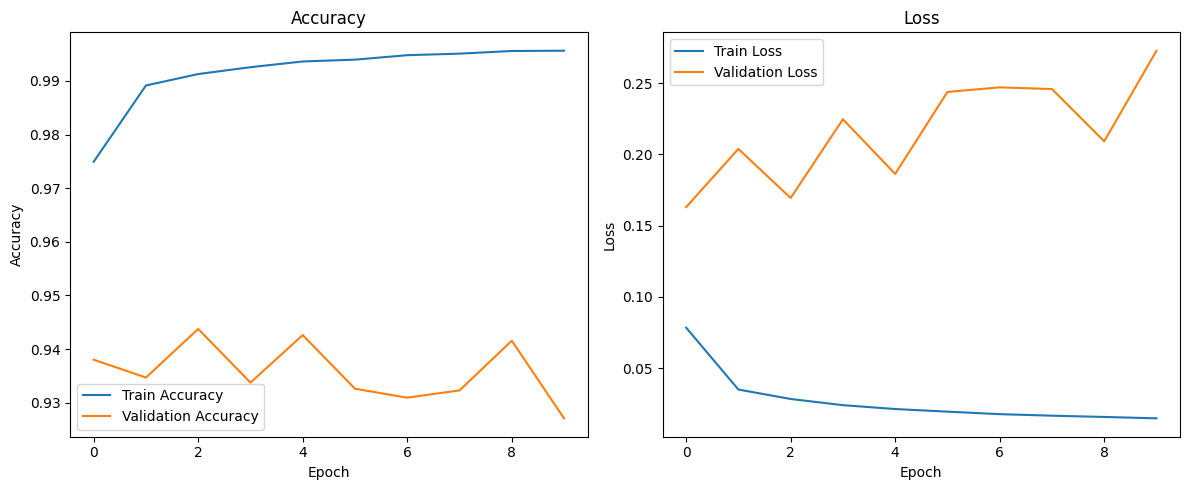

In [24]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
#plt.savefig("../../results/images/16_dense128_dropout0.3_training_plot.png")
plt.show()

In [27]:
from keras.applications.resnet50 import preprocess_input

IMG_SIZE=224
BATCH_SIZE=100
DATA_PATH="../../data/processed/02_kaggle_dataset/train"

train_datagen=ImageDataGenerator(preprocessing_function=preprocess_input,
                                 validation_split=0.3)
val_datagen=ImageDataGenerator(preprocessing_function=preprocess_input,
                               validation_split=0.3)
                                        
train_generator=train_datagen.flow_from_directory(DATA_PATH,
                                                  target_size=(IMG_SIZE, IMG_SIZE),
                                                  batch_size=BATCH_SIZE,
                                                  shuffle=True,
                                                  class_mode="binary",
                                                  subset="training")

validation_generator=val_datagen.flow_from_directory(DATA_PATH,
                                                  target_size=(IMG_SIZE, IMG_SIZE),
                                                  batch_size=BATCH_SIZE,
                                                  class_mode="binary",
                                                  subset="validation")

Found 33600 images belonging to 2 classes.
Found 14400 images belonging to 2 classes.


In [ ]:
model_res50=Sequential()

model_res50.add(ResNet50(include_top=False, pooling="avg", weights="imagenet"))
model_res50.add(Dense(1, activation="sigmoid"))
model_res50.layers[0].trainable = False
#model_res50.summary()

steps_per_epoch_training=len(train_generator)
steps_per_epoch_validation=len(validation_generator)

model_res50.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

In [31]:
history=model_res50.fit(train_generator, validation_data=validation_generator,
                        steps_per_epoch=steps_per_epoch_training, validation_steps=steps_per_epoch_validation,
                        epochs=10, verbose=1)

Epoch 1/10
336/336 [==============================] - 98s 289ms/step - loss: 0.0830 - accuracy: 0.9742 - val_loss: 0.1686 - val_accuracy: 0.9358
Epoch 2/10
336/336 [==============================] - 96s 285ms/step - loss: 0.0334 - accuracy: 0.9902 - val_loss: 0.1844 - val_accuracy: 0.9353
Epoch 3/10
336/336 [==============================] - 95s 283ms/step - loss: 0.0265 - accuracy: 0.9917 - val_loss: 0.1867 - val_accuracy: 0.9378
Epoch 4/10
336/336 [==============================] - 95s 284ms/step - loss: 0.0224 - accuracy: 0.9935 - val_loss: 0.1893 - val_accuracy: 0.9369
Epoch 5/10
336/336 [==============================] - 95s 284ms/step - loss: 0.0202 - accuracy: 0.9935 - val_loss: 0.1935 - val_accuracy: 0.9398
Epoch 6/10
336/336 [==============================] - 95s 283ms/step - loss: 0.0185 - accuracy: 0.9940 - val_loss: 0.2236 - val_accuracy: 0.9362
Epoch 7/10
336/336 [==============================] - 95s 282ms/step - loss: 0.0166 - accuracy: 0.9947 - val_loss: 0.2106 - val_ac

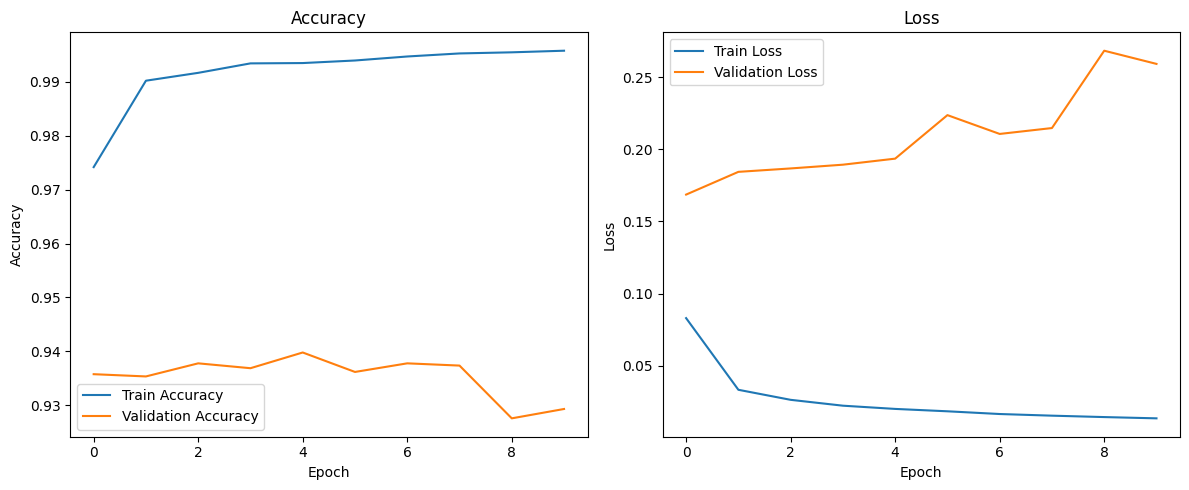

In [32]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
# plt.savefig("../../results/images/16_dense128_dropout0.3_training_plot.png")
plt.show()

In [33]:
import os
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.applications.resnet50 import preprocess_input

# Seed 고정
SEED=42
os.environ["PYTHONHASHSEED"]=str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# GPU 설정
gpus=tf.config.experimental.list_physical_devices("GPU")
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

print("Num GPUs Available: ", len(tf.config.list_physical_devices("GPU")))

# 경로 및 하이퍼파라미터
IMG_SIZE=224
BATCH_SIZE=100
DATA_PATH="../../data/processed/02_kaggle_dataset/train"

# 데이터 생성기 정의
train_datagen=ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2
)
val_datagen=ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2
)

# 데이터 로드
train_generator=train_datagen.flow_from_directory(
    DATA_PATH,
    target_size=(IMG_SIZE, IMG_SIZE),
    color_mode="rgb",
    batch_size=BATCH_SIZE,
    class_mode="binary",
    subset="training",
    shuffle=True,
    seed=SEED
)

val_generator=val_datagen.flow_from_directory(
    DATA_PATH,
    target_size=(IMG_SIZE, IMG_SIZE),
    color_mode="rgb",
    batch_size=BATCH_SIZE,
    class_mode="binary",
    subset="validation",
    shuffle=False,
    seed=SEED
)

# ResNet50 기반 모델 구성
base_model=ResNet50(weights="imagenet", include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_model.trainable=True
for layer in base_model.layers[:-30]:
    layer.trainable=False

model=Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation="relu"),
    Dropout(0.5),
    Dense(1, activation="sigmoid")
])

model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

# 콜백 설정
save_dir="../../src/models/09_drowsiness_cls"
os.makedirs(save_dir, exist_ok=True)

checkpoint=ModelCheckpoint(filepath=os.path.join(save_dir, "best_model.keras"),
                           save_best_only=True, monitor="val_accuracy", mode="max", verbose=1)
es=EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True, verbose=1)

# 학습
history=model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,
    callbacks=[checkpoint, es]
)

# 시각화
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()

Num GPUs Available:  1
Found 38400 images belonging to 2 classes.
Found 9600 images belonging to 2 classes.
Epoch 1/30
384/384 [==============================] - ETA: 0s - loss: 0.0238 - accuracy: 0.9914
Epoch 1: val_accuracy improved from -inf to 0.93771, saving model to ../../src/models/09_drowsiness_cls/best_model.keras
384/384 [==============================] - 119s 284ms/step - loss: 0.0238 - accuracy: 0.9914 - val_loss: 0.4700 - val_accuracy: 0.9377
Epoch 2/30
384/384 [==============================] - ETA: 0s - loss: 0.0089 - accuracy: 0.9975
Epoch 2: val_accuracy did not improve from 0.93771
384/384 [==============================] - 107s 279ms/step - loss: 0.0089 - accuracy: 0.9975 - val_loss: 0.5553 - val_accuracy: 0.9135
Epoch 3/30
384/384 [==============================] - ETA: 0s - loss: 0.0060 - accuracy: 0.9983
Epoch 3: val_accuracy improved from 0.93771 to 0.95240, saving model to ../../src/models/09_drowsiness_cls/best_model.keras
384/384 [=============================

KeyboardInterrupt: 